Lambda School Data Science

*Unit 2, Sprint 3, Module 1*

---


# Define ML problems

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your decisions.

- [ ] Choose your target. Which column in your tabular dataset will you predict?
- [ ] Is your problem regression or classification?
- [ ] How is your target distributed?
    - Classification: How many classes? Are the classes imbalanced?
    - Regression: Is the target right-skewed? If so, you may want to log transform the target.
- [ ] Choose your evaluation metric(s).
    - Classification: Is your majority class frequency >= 50% and < 70% ? If so, you can just use accuracy if you want. Outside that range, accuracy could be misleading. What evaluation metric will you choose, in addition to or instead of accuracy?
    - Regression: Will you use mean absolute error, root mean squared error, R^2, or other regression metrics?
- [ ] Choose which observations you will use to train, validate, and test your model.
    - Are some observations outliers? Will you exclude them?
    - Will you do a random split or a time-based split?
- [ ] Begin to clean and explore your data.
- [ ] Begin to choose which features, if any, to exclude. Would some features "leak" future information?

If you haven't found a dataset yet, do that today. [Review requirements for your portfolio project](https://lambdaschool.github.io/ds/unit2) and choose your dataset.

Some students worry, ***what if my model isn't “good”?*** Then, [produce a detailed tribute to your wrongness. That is science!](https://twitter.com/nathanwpyle/status/1176860147223867393)

In [1]:
%%capture
!pip install category_encoders==2.*

# Working locally:
DATA_PATH = '../data/'

### Import Libraries

In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option("display.max_columns", 75)
pd.set_option("display.max_rows", 75)

from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.metrics import classification_report, roc_curve, plot_confusion_matrix, plot_roc_curve
from sklearn.model_selection import train_test_split

In [122]:
def clean_up_binary_columns(cell_contents):
  if isinstance(cell_contents, str):
    return 1
  else:
    return 0

In [129]:
def wrangle(filepath):
  df = pd.read_csv(filepath, parse_dates=['DATE'], index_col='DATE')

  # Drop Columns with a high number of NaNs
  df.dropna(axis=1, thresh=300, inplace=True)
 
  # High Cardinality Categorical Columns
  categorical_cols = df.select_dtypes('object').columns
  threshold = 10
  high_card_cols = [col for col in categorical_cols if df[col].nunique() > threshold]
  df.drop(high_card_cols, axis=1, inplace=True)
  
  #Feature engineering 
  df['Total_fatalities'] = df['PERSONS KILLED'] + df['PEDESTRIANS KILLED'] + df['CYCLISTS KILLED'] + df['MOTORISTS KILLED']
  df['Total_injured'] = df['PERSONS INJURED'] + df['PEDESTRIANS INJURED'] + df['CYCLISTS INJURED'] + df['MOTORISTS INJURED']
  df['Total_victims'] = df['Total_fatalities'] + df['Total_injured']
  df['New_Borough'] = df['BOROUGH'].replace({'STATEN ISLAND':0, 'BRONX':1, 'MANHATTAN':2, 'QUEENS':3,'BROOKLYN':4})
  
  # Drop 'UNIQUE KEY' column
  df = df.drop(columns='UNIQUE KEY')
  df = df.drop(columns='BOROUGH')
      
  df = df.dropna(axis=0, subset=['ZIP CODE'])
  df = df.dropna(axis=0, subset=['LATITUDE'])
  df = df.dropna(axis=0, subset=['LONGITUDE'])
  return df

df = wrangle(DATA_PATH+'database.csv')  

print(df.shape)
df.head()

(308948, 15)


,ZIP CODE,LATITUDE,LONGITUDE,PERSONS INJURED,PERSONS KILLED,PEDESTRIANS INJURED,PEDESTRIANS KILLED,CYCLISTS INJURED,CYCLISTS KILLED,MOTORISTS INJURED,MOTORISTS KILLED,Total_fatalities,Total_injured,Total_victims,New_Borough
DATE,,,,,,,,,,,,,,,
2015-01-01,11358.0,40.751847,-73.787862,0,0,0,0,0,0,0,0,0,0,0,3.0
2015-01-01,11205.0,40.689445,-73.955121,0,0,0,0,0,0,0,0,0,0,0,4.0
2015-01-01,11213.0,40.673845,-73.925080,0,0,0,0,0,0,0,0,0,0,0,4.0
2015-01-01,11203.0,40.656684,-73.929896,2,0,0,0,0,0,2,0,0,4,4,4.0
2015-01-01,11105.0,40.776519,-73.915920,0,0,0,0,0,0,0,0,0,0,0,3.0


In [ ]:
#hcc= ['LOCATION', 'ON STREET NAME', 'CROSS STREET NAME', 'OFF STREET NAME',]

In [125]:
df.columns

Index(['ZIP CODE', 'LATITUDE', 'LONGITUDE', 'PERSONS INJURED',
       'PERSONS KILLED', 'PEDESTRIANS INJURED', 'PEDESTRIANS KILLED',
       'CYCLISTS INJURED', 'CYCLISTS KILLED', 'MOTORISTS INJURED',
       'MOTORISTS KILLED', 'Total_fatalities', 'Total_injured',
       'Total_victims', 'New_Borough'],
      dtype='object')

In [58]:
#df['BOROUGH'].value_counts()

In [130]:
# no missing values 
df.isnull().sum()

ZIP CODE               0
LATITUDE               0
LONGITUDE              0
PERSONS INJURED        0
PERSONS KILLED         0
PEDESTRIANS INJURED    0
PEDESTRIANS KILLED     0
CYCLISTS INJURED       0
CYCLISTS KILLED        0
MOTORISTS INJURED      0
MOTORISTS KILLED       0
Total_fatalities       0
Total_injured          0
Total_victims          0
New_Borough            0
dtype: int64

In [54]:
#df['New_Borough'] = df['BOROUGH'].replace({'STATEN ISLAND':0, 'BRONX':1, 'MANHATTAN':2, 'QUEENS':3,'BROOKLYN':4})

In [131]:
df.head(5)

,ZIP CODE,LATITUDE,LONGITUDE,PERSONS INJURED,PERSONS KILLED,PEDESTRIANS INJURED,PEDESTRIANS KILLED,CYCLISTS INJURED,CYCLISTS KILLED,MOTORISTS INJURED,MOTORISTS KILLED,Total_fatalities,Total_injured,Total_victims,New_Borough
DATE,,,,,,,,,,,,,,,
2015-01-01,11358.0,40.751847,-73.787862,0,0,0,0,0,0,0,0,0,0,0,3.0
2015-01-01,11205.0,40.689445,-73.955121,0,0,0,0,0,0,0,0,0,0,0,4.0
2015-01-01,11213.0,40.673845,-73.925080,0,0,0,0,0,0,0,0,0,0,0,4.0
2015-01-01,11203.0,40.656684,-73.929896,2,0,0,0,0,0,2,0,0,4,4,4.0
2015-01-01,11105.0,40.776519,-73.915920,0,0,0,0,0,0,0,0,0,0,0,3.0


## Split The Data 

In [140]:
target= 'New_Borough'
y = df[target]
X = df.drop(columns= target)

In [141]:

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33, random_state=42)

In [142]:
# Sanity check
assert len(X_train) + len(X_val) == len(X)

## Establish Baseline

In [91]:
y_train.value_counts(normalize=True)

4.0    0.311887
3.0    0.263093
2.0    0.248726
1.0    0.135225
0.0    0.041069
Name: New_Borough, dtype: float64

In [90]:
# Common class is the baseline
print("Baseline Accuracy", y_train.value_counts(normalize=True).max())

Baseline Accuracy 0.3118867605497717


## Build Model

In [94]:
df_model = make_pipeline(OrdinalEncoder(), 
                         SimpleImputer(), 
                         DecisionTreeClassifier())

df_model.fit(X_train, y_train)

Pipeline(steps=[('ordinalencoder', OrdinalEncoder()),
                ('simpleimputer', SimpleImputer()),
                ('decisiontreeclassifier', DecisionTreeClassifier())])

In [97]:
model_rf = make_pipeline(OrdinalEncoder(), 
                         SimpleImputer(), 
                         RandomForestClassifier())

model_rf.fit(X_train, y_train)
model_rf

Pipeline(steps=[('ordinalencoder', OrdinalEncoder()),
                ('simpleimputer', SimpleImputer()),
                ('randomforestclassifier', RandomForestClassifier())])

## Make sure there is no leakeage

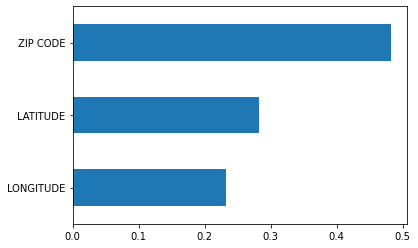

In [143]:
importances = model.named_steps['randomforestclassifier'].feature_importances_
features = X_train.columns
pd.Series(importances,index=features).sort_values().tail(3).plot(kind='barh');

## Tune Model

In [112]:
model = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    RandomForestClassifier(n_estimators=25,
                           n_jobs=-1,
                           random_state=42)
)

model.fit(X_train, y_train);

In [146]:
print('Training Accuracy:', model.score(X_train, y_train) )
print('Validation Accuracy:',model.score(X_val, y_val) )

Training Accuracy: 0.9997681103408295


ValueError: Found unknown categories [10155.0, 10167.0, 10278.0] in column 0 during transform

In [148]:
plot_confusion_matrix(
    model,
    X_val,
    y_val,
    values_format = '.0f',
    display_labels = ['no repairs needed','needs repairs'])

ValueError: Found unknown categories [10155.0, 10167.0, 10278.0] in column 0 during transform

In [65]:
print("Training Accuracy - Logistic Regression", model_lr.score(X_train, y_train))
print("Validation Accuracy - Logistic Regression", model_lr.score(X_val, y_val))

Training Accuracy - Logistic Regression 1.0
Validation Accuracy - Logistic Regression 0.9999901915588556


In [66]:
print("Training Accuracy - Random Forest", model_rf.score(X_train, y_train))
print("Validation Accuracy - Random Forest", model_rf.score(X_val, y_val))

Training Accuracy - Random Forest 1.0
Validation Accuracy - Random Forest 1.0


In [67]:
df.corr()

,ZIP CODE,LATITUDE,LONGITUDE,PERSONS INJURED,PERSONS KILLED,PEDESTRIANS INJURED,PEDESTRIANS KILLED,CYCLISTS INJURED,CYCLISTS KILLED,MOTORISTS INJURED,MOTORISTS KILLED,Total_fatalities,Total_injured,Total_victims,New_Borough
ZIP CODE,1.000000,-0.157026,0.097987,0.059063,0.003679,-0.001169,0.001537,-0.006189,0.001055,0.065935,0.003898,0.003703,0.059164,0.059237,0.733642
LATITUDE,-0.157026,1.000000,-0.902413,-0.006026,-0.001597,0.003553,-0.000921,0.000628,-0.000524,-0.008347,-0.001315,-0.001607,-0.006105,-0.006173,-0.175576
LONGITUDE,0.097987,-0.902413,1.000000,0.006509,-0.000169,-0.001640,-0.000335,-0.006250,-0.000594,0.009445,0.000475,-0.000165,0.006559,0.006538,0.036986
PERSONS INJURED,0.059063,-0.006026,0.006509,1.000000,0.013057,0.326148,0.001679,0.189651,0.002811,0.876670,0.018874,0.012998,0.994906,0.993697,0.031557
PERSONS KILLED,0.003679,-0.001597,-0.000169,0.013057,1.000000,0.000019,0.771802,-0.002878,0.298269,0.014706,0.552450,0.998723,0.013012,0.062266,0.000636
PEDESTRIANS INJURED,-0.001169,0.003553,-0.001640,0.326148,0.000019,1.000000,0.003401,-0.031373,-0.002102,-0.050872,-0.003474,0.000007,0.335311,0.334688,0.006549
PEDESTRIANS KILLED,0.001537,-0.000921,-0.000335,0.001679,0.771802,0.003401,1.000000,-0.003357,-0.000210,0.001439,-0.000348,0.769498,0.001782,0.039747,0.002457
CYCLISTS INJURED,-0.006189,0.000628,-0.006250,0.189651,-0.002878,-0.031373,-0.003357,1.000000,0.003280,-0.036596,-0.002221,-0.002877,0.192336,0.191837,0.025466
CYCLISTS KILLED,0.001055,-0.000524,-0.000594,0.002811,0.298269,-0.002102,-0.000210,0.003280,1.000000,0.002916,-0.000139,0.297379,0.002735,0.017403,-0.000099
MOTORISTS INJURED,0.065935,-0.008347,0.009445,0.876670,0.014706,-0.050872,0.001439,-0.036596,0.002916,1.000000,0.022332,0.014737,0.888192,0.887268,0.023699


C:\Users\arnel\anaconda3\envs\unit2\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\arnel\anaconda3\envs\unit2\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\arnel\anaconda3\envs\unit2\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00    101903
           1       1.00      1.00      1.00        50
           2       0.00      0.00      0.00         0

    accuracy                           1.00    101953
   macro avg       0.67      0.67      0.67    101953
weighted avg       1.00      1.00      1.00    101953



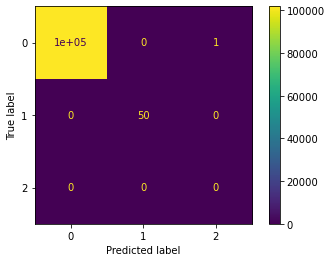

In [68]:
print(classification_report(y_val, model_lr.predict(X_val)))
plot_confusion_matrix(model_lr, X_val, y_val)
plt.show()

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    101903
           1       1.00      1.00      1.00        50

    accuracy                           1.00    101953
   macro avg       1.00      1.00      1.00    101953
weighted avg       1.00      1.00      1.00    101953



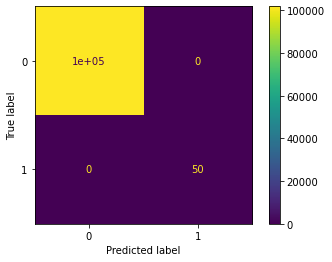

In [70]:
print(classification_report(y_val, model_rf.predict(X_val)))
plot_confusion_matrix(model_rf, X_val, y_val)
plt.show()